# Transformation & Interpolation

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from myshow import myshow


filename = "images/dojo.jpg"
offset = (100, 150)
rotate = 45  #degrees
center = (125, 125)

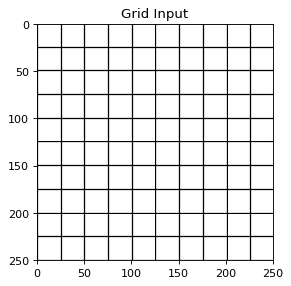

In [168]:
# SimpleITK
import SimpleITK as sitk 

grid = sitk.GridSource(outputPixelType=sitk.sitkUInt16,
    size=(250, 250),
    sigma=(0.5, 0.5),
    gridSpacing=(25.0, 25.0),
    gridOffset=(0.0, 0.0),
    spacing=(1.,1.))
myshow(grid, 'Grid Input')

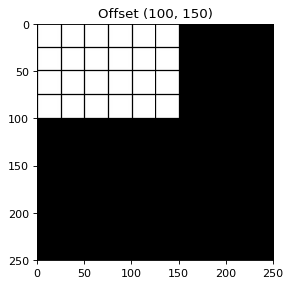

In [169]:
dimension = 2         
translation = sitk.TranslationTransform(dimension, offset)  # offset can be any vector-like data  

translated = sitk.Resample(grid, translation, sitk.sitkNearestNeighbor, 0.0, sitk.sitkUInt16)
myshow(translated, title="Offset {}".format(offset))

<h2> Review of affine matrix </h2>
<p><a href="https://commons.wikimedia.org/wiki/File:2D_affine_transformation_matrix.svg#/media/File:2D_affine_transformation_matrix.svg">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/2D_affine_transformation_matrix.svg/1200px-2D_affine_transformation_matrix.svg.png" alt="2D affine transformation matrix.svg">
</a>
<br>By <a href="//commons.wikimedia.org/wiki/User:Cmglee" title="User:Cmglee">Cmglee</a> - <span class="int-own-work" lang="en" xml:lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=35180401">Link</a></p>

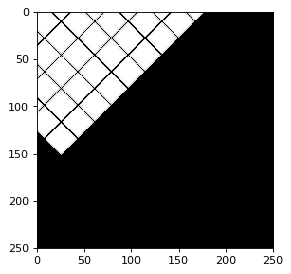

In [170]:
from math import radians
# Affine
affine = sitk.AffineTransform(dimension)
affine.SetCenter(center)
# Order is important!
affine.Translate(offset)
affine.Rotate(0, 1, radians(rotate))
# affine.Translate(offset)
translated = sitk.Resample(grid, affine, sitk.sitkNearestNeighbor, 0.0, sitk.sitkUInt16)
myshow(translated)

In [171]:
# scikit-image
from skimage import transform as sktx

def convertAffineMatrix(affine):
    """ Convert a SimpleITK matrix to a form suitable for skimage """
    matrix = np.eye(3)
    values = affine.GetParameters()
    matrix[0:2, 0] = values[0:2]
    matrix[0:2, 1] = values[2:4]
    matrix[0:2, 2] = [-values[5], values[4]]  # note switch
    return matrix

print convertAffineMatrix(affine)

[[   0.70710678   -0.70710678  -35.35533906]
 [   0.70710678    0.70710678  176.7766953 ]
 [   0.            0.            1.        ]]


In [172]:
# scikit-image
from skimage import transform as sktx

# Order is important!
affine = sktx.AffineTransform(translation=offset) 
affine += sktx.AffineTransform(rotation=radians(rotate))
# affine += sktx.AffineTransform(translation=(offset))
print affine.params

[[   0.70710678   -0.70710678  -35.35533906]
 [   0.70710678    0.70710678  176.7766953 ]
 [   0.            0.            1.        ]]


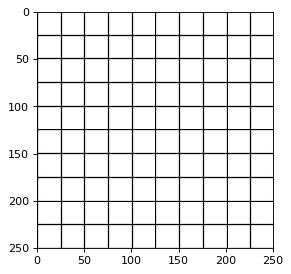

In [173]:
grid = sitk.GetArrayFromImage(grid)
myshow(grid)

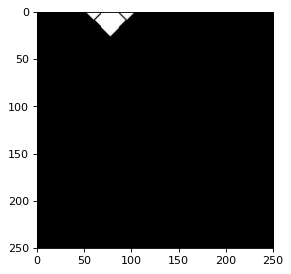

In [174]:
myshow(sktx.warp(grid, affine))  # doesn't rotate about the center!

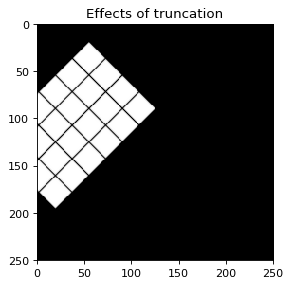

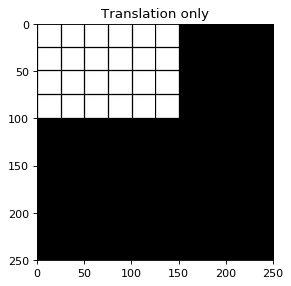

In [175]:
affine = sktx.AffineTransform(translation=offset)
x = sktx.rotate(sktx.warp(grid, affine), center=center, angle=rotate)
myshow(x, title="Effects of truncation");
myshow(sktx.warp(grid, affine), title="Translation only")  # scikit-image truncates data outside 250x250

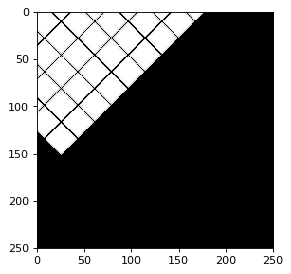

In [176]:
myshow(translated)

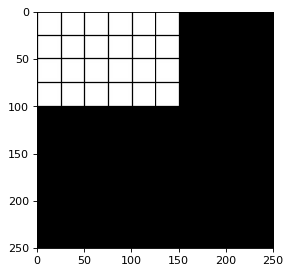

In [177]:
# OpenCV
import cv2
import numpy as np

rows,cols = grid.shape
M = np.float32([[1, 0, -offset[0]],
                [0, 1, -offset[1]]])  # note the negatives
dst = cv2.warpAffine(grid, M, (cols, rows))  # note rows and cols order
myshow(dst)

[[   0.70710678   -0.70710678   35.35533906]
 [   0.70710678    0.70710678 -176.7766953 ]]


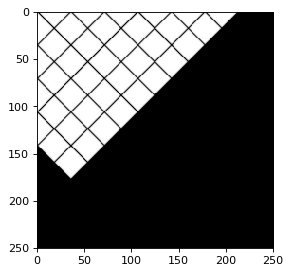

In [178]:
# Use 
affine = sktx.AffineTransform(translation=[-x for x in offset])  # note negative offset
affine += sktx.AffineTransform(rotation=radians(rotate))
print affine.params[:-1, :]

dst = cv2.warpAffine(grid, affine.params[:-1, :], (cols, rows))  # note rows and cols order and truncated matrix
myshow(dst)

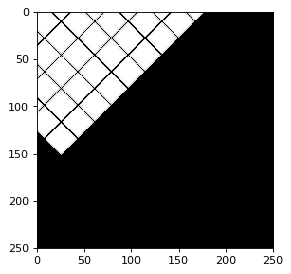

In [179]:
myshow(translated)

## Interpolations

We'll demonstrate the different interpolators available for image resampling.  Their effect is demonstrated on the <a href="http://www.cs.cornell.edu/~srm/publications/Vis94-filters-abstract.html">Marschner-Lobb</a> image.

In [180]:
def marschner_lobb(size=40, alpha=0.25, f_M=6.0):
    img = sitk.PhysicalPointSource(sitk.sitkVectorFloat32, [size]*3, [-1]*3, [2.0/size]*3)
    imgx = sitk.VectorIndexSelectionCast(img, 0)
    imgy = sitk.VectorIndexSelectionCast(img, 1)
    imgz = sitk.VectorIndexSelectionCast(img, 2)
    del img
    r = sitk.Sqrt(imgx**2 + imgy**2)
    del imgx, imgy
    pr = sitk.Cos((2.0*math.pi*f_M)*sitk.Cos((math.pi/2.0)*r))
    return (1.0 - sitk.Sin((math.pi/2.0)*imgz) + alpha*(1.0+pr))/(2.0*(1.0+alpha))

def mlshow(img, title=None, margin=0.05, show=True):
    if not isinstance(img, sitk.Image):
        img = sitk.GetImageFromArray(img)
        
    if (img.GetDimension() == 3):
        img = sitk.Tile((img[img.GetSize()[0]//2, :, :],
                         img[:, img.GetSize()[1]//2, :],
                         img[:, :, img.GetSize()[2]//2]), [2,2])
    aimg = sitk.GetArrayFromImage(img)
    xsize, ysize = aimg.shape
    dpi = 80
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    t = ax.imshow(aimg, interpolation=None)
    if len(aimg.shape) == 2:
        t.set_cmap("gray")
    if(title):
        plt.title(title)
    if show:
        plt.show()
    return t

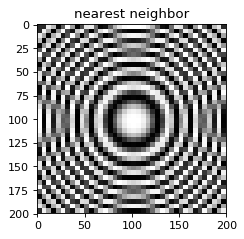

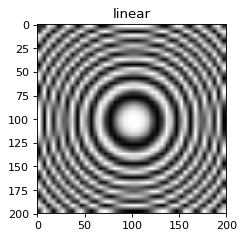

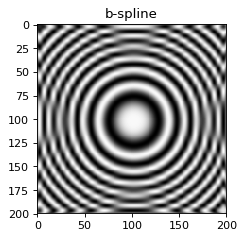

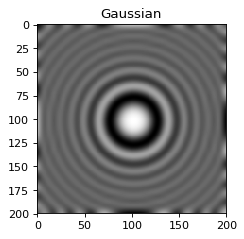

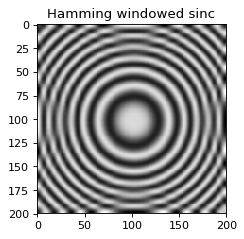

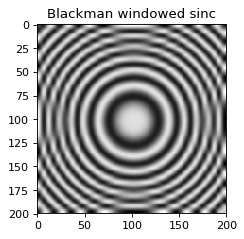

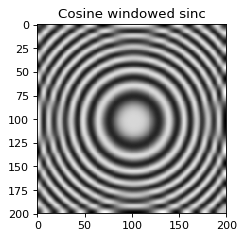

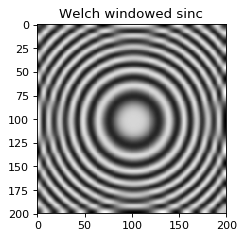

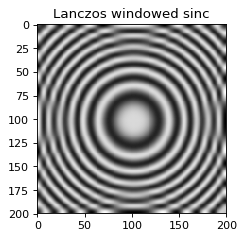

In [181]:
ml = marschner_lobb()
ml = ml[:, :, ml.GetSize()[-1] // 2]
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkNearestNeighbor), title="nearest neighbor");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkLinear), title="linear");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkBSpline), title="b-spline");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkGaussian), title="Gaussian");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkHammingWindowedSinc), title="Hamming windowed sinc");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkBlackmanWindowedSinc), title="Blackman windowed sinc");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkCosineWindowedSinc), title="Cosine windowed sinc");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkWelchWindowedSinc), title="Welch windowed sinc");
mlshow(sitk.Expand(ml, [5]*3, sitk.sitkLanczosWindowedSinc), title="Lanczos windowed sinc");

The order of interpolation in scikit-image. The order has to be in the range 0-5:
- 0: Nearest-neighbor
- 1: Bi-linear (default)
- 2: Bi-quadratic
- 3: Bi-cubic
- 4: Bi-quartic 
- 5: Bi-quintic

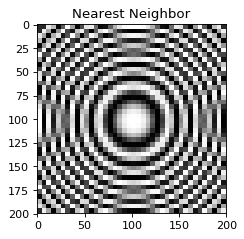

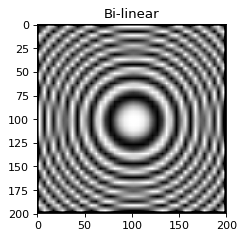

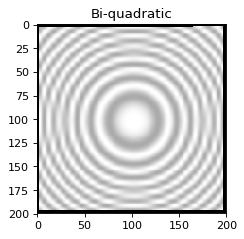

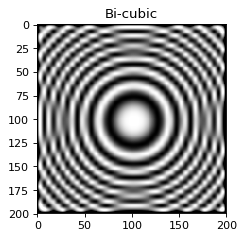

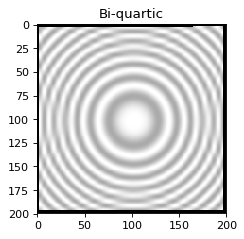

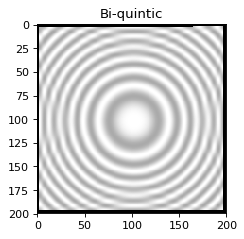

In [194]:
from skimage.transform import rescale, warp

ml = sitk.GetArrayFromImage(marschner_lobb())
ml = ml[ml.shape[-1] // 2, :, :]

mlshow(rescale(ml, [5]*2, order=0, preserve_range=True), title='Nearest Neighbor');
mlshow(rescale(ml, [5]*2, order=1, preserve_range=True), title='Bi-linear');
mlshow(rescale(ml, [5]*2, order=2, preserve_range=True), title='Bi-quadratic');
mlshow(rescale(ml, [5]*2, order=3, preserve_range=True), title='Bi-cubic');
mlshow(rescale(ml, [5]*2, order=4, preserve_range=True), title='Bi-quartic');
mlshow(rescale(ml, [5]*2, order=5, preserve_range=True), title='Bi-quintic');

In [ ]:
# scikit-image edge interpolations

import numpy as np
import matplotlib.pyplot as plt

from skimage.util import pad


img = np.zeros((16, 16))
img[:8, :8] += 1
img[:4, :4] += 1
img[:2, :2] += 1
img[:1, :1] += 1
img[15, :16] = 3
img[0:15:3, 15] = 4
img[8, 8] = 5
fig = plt.figure(figsize=(5,5))
plt.imshow(img)

modes = ['constant', 'edge', 'wrap', 'reflect', 'symmetric']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes.flatten()

for n, mode in enumerate(modes):
    img_padded = pad(img, pad_width=img.shape[0], mode=mode)
    ax[n].imshow(img_padded, cmap=plt.cm.gray, interpolation='nearest')
    ax[n].plot([15.5, 15.5, 31.5, 31.5, 15.5],
               [15.5, 31.5, 31.5, 15.5, 15.5], 'y--', linewidth=0.5)
    ax[n].set_title(mode)

for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

plt.tight_layout()
plt.show()

<a href="http://docs.opencv.org/3.1.0/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121"> OpenCV Interpolation codes</a>

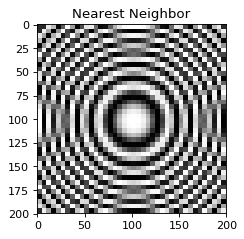

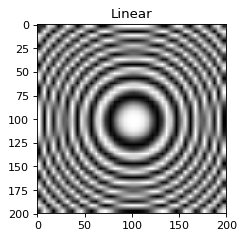

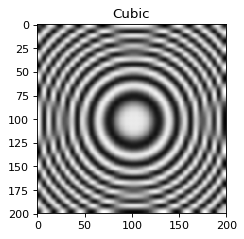

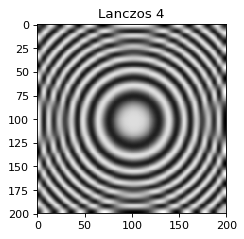

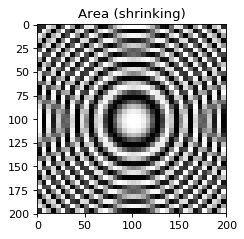

In [195]:
# OpenCV

import cv2

ml = sitk.GetArrayFromImage(marschner_lobb())
ml = ml[ml.shape[-1] // 2, :, :]

mlshow(cv2.resize(ml, None, fx=5, fy=5, interpolation=cv2.INTER_NEAREST), title='Nearest Neighbor');
mlshow(cv2.resize(ml, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR), title='Linear');
mlshow(cv2.resize(ml, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC), title='Cubic');
mlshow(cv2.resize(ml, None, fx=5, fy=5, interpolation=cv2.INTER_LANCZOS4), title='Lanczos 4');
mlshow(cv2.resize(ml, None, fx=5, fy=5, interpolation=cv2.INTER_AREA), title='Area (shrinking)');

# Exercise

Compare the results of the linear interpolator for all three tools.  

- Is there a difference?  
- What about for cubic? nearest neighbor?
- Which do __you__ believe is more accurate and why?